<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Intoduction-to-RNNs-for-time-series" data-toc-modified-id="Intoduction-to-RNNs-for-time-series-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Intoduction to RNNs for time series</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Import-dataset" data-toc-modified-id="Import-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Import dataset</a></span></li><li><span><a href="#PACF-=-Partial-Autocorrelation" data-toc-modified-id="PACF-=-Partial-Autocorrelation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>PACF = Partial Autocorrelation</a></span></li><li><span><a href="#Final-version-of-the-dataset" data-toc-modified-id="Final-version-of-the-dataset-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Final version of the dataset</a></span></li><li><span><a href="#Train-and-test-sets" data-toc-modified-id="Train-and-test-sets-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train and test sets</a></span></li><li><span><a href="#RNNs" data-toc-modified-id="RNNs-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>RNNs</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-warning">
<font color=black>

**What?** Price forecasting with RNNs

</font>
</div>

# Intoduction to RNNs for time series
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- It was created especially for sequences with the ability to maintain its hidden state and learn dependencies over time, is Turing complete and is able to deal with sequences of any length. 

- But as it has been shown in recent research, we barely use these benefits in practice. Moreover, we encounter numerous problems that won’t make them able to work with too long sequences (and that’s what we have with streaming signal processing with the high-frequency sampling rate, e.g. 500–100 Hz), for more details check the reading list in the conclusions of this article. 

- From my personal experience, recurrent nets are good only when we deal with rather short sequences (10–100 time steps) with multiple variables on each time step (can be multivariate time series or word embeddings).

</font>
</div>

# Import modules
<hr style = "border:2px solid black" ></hr>

In [1]:
import numpy as np
import pandas as pd
import urllib
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from keras.models import Sequential
from keras.optimizers import SGD 
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN, RNN

# Import dataset
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-info">
<font color=black>

-  If you have lived in Singapore, you will know that anyone who wants to register a new vehicle must first obtain a Certificate of Entitlement (**COE**). 
- It gives the holder the right to vehicle ownership and access to the very limited road space in the tropical island city-state. The number of COEs issued is limited and they can only be obtained through an open bidding system

</font>
</div>

In [2]:
"""
Use this code snippet if you prefer to automatically donwload the dataset form the web
url ="https://goo.gl/WymYzd" 
localPath = "./COE.xls" 
urllib.urlretrieve(url, loc)
"""

'\nUse this code snippet if you prefer to automatically donwload the dataset form the web\nurl ="https://goo.gl/WymYzd" \nlocalPath = "./COE.xls" \nurllib.urlretrieve(url, loc)\n'

In [3]:
Excel_file = pd.ExcelFile("../../DATASETS/COE.xls")

In [4]:
Excel_file

In [5]:
# How many sheets are there? Just one.
print(Excel_file.sheet_names)

['COE data']


In [6]:
spreadsheet = Excel_file.parse("COE data")

In [7]:
spreadsheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    265 non-null    datetime64[ns]
 1   COE$    265 non-null    float64       
 2   COE$_1  265 non-null    float64       
 3   #Bids   265 non-null    int64         
 4   Quota   265 non-null    int64         
 5   Open?   265 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 12.5 KB


<div class="alert alert-info">
<font color=black>

- We see the spreadsheet contains six columns with 265 rows (entries). 
- The first contains the date of the COE auction, and the remaining columns the other five variables.
- The variable COE$ contains the Certificate of Entitlement historical price. 
- We will use it as our target variable and store it in an object called data:

</font>
</div>

In [8]:
# data = target
data = spreadsheet["COE$"]

In [9]:
data.head(5)

0     7400.0
1    11100.0
2     5002.0
3     3170.0
4     3410.0
Name: COE$, dtype: float64

In [10]:
spreadsheet["DATE"][192:204]

192   2004-01-15
193   2004-02-01
194   2002-02-15
195   2004-03-01
196   2004-03-15
197   2004-04-01
198   2002-04-15
199   2004-05-01
200   2004-05-15
201   2004-06-01
202   2002-06-15
203   2004-07-01
Name: DATE, dtype: datetime64[ns]

<div class="alert alert-block alert-info">
<font color=black><br>

- Did you notice the error for 15th February, 15th April and 15th June? 
- All are reported as the year 2002; they should say 2004. 
- This quite is a common type of coding error. **We'll correct it**.

<br></font>
</div>

In [11]:
spreadsheet.at[194, "DATE"] = "2004−02−15 00:00:00"
spreadsheet.at[198, "DATE"] = "2004−04−15 00:00:00" 
spreadsheet.at[202, "DATE"] = "2004−06−15 00:00:00" 

In [12]:
spreadsheet["DATE"][192:204]

192    2004-01-15 00:00:00
193    2004-02-01 00:00:00
194    2004−02−15 00:00:00
195    2004-03-01 00:00:00
196    2004-03-15 00:00:00
197    2004-04-01 00:00:00
198    2004−04−15 00:00:00
199    2004-05-01 00:00:00
200    2004-05-15 00:00:00
201    2004-06-01 00:00:00
202    2004−06−15 00:00:00
203    2004-07-01 00:00:00
Name: DATE, dtype: object

In [13]:
clean_df = spreadsheet

In [14]:
# Just checking it is all been saved OK
clean_df[194:204]

,DATE,COE$,COE$_1,#Bids,Quota,Open?
194,2004−02−15 00:00:00,24016.0,22801.0,1678,1170,1
195,2004-03-01 00:00:00,23801.0,24016.0,1402,1154,1
196,2004-03-15 00:00:00,25492.0,23801.0,1615,1159,1
197,2004-04-01 00:00:00,26401.0,25492.0,1481,1156,1
198,2004−04−15 00:00:00,28339.0,26401.0,1500,1039,1
199,2004-05-01 00:00:00,28108.0,28339.0,1439,1048,1
200,2004-05-15 00:00:00,28000.0,28108.0,1372,1037,1
201,2004-06-01 00:00:00,28101.0,28000.0,1489,1032,1
202,2004−06−15 00:00:00,30301.0,28101.0,1473,1032,1
203,2004-07-01 00:00:00,29999.0,30301.0,1585,1030,1


<div class="alert alert-block alert-info">
<font color=black><br>

- Deep neural networks are **sensitive** to the scale of the input data, especially when the sigmoid or tanh activation functions are used. 
- It is good practice to **re-scale** the data to the range -1 to +1 or 0 to 1. 

<br></font>
</div>

In [15]:
scaler = preprocessing.MinMaxScaler(copy=True, feature_range=(0, 1))

<div class="alert alert-block alert-info">
<font color=black><br>

- **copy=True** (default) if the input is already a numpy array.
- **copy = False** to perform in place row normalization and avoid a copy.
- Before using the scaler have to data into a numpy array first.

<br></font>
</div>

In [16]:
type(data)

pandas.core.series.Series

In [17]:
x = data
x = np.array(x).reshape((len(x), ))

In [18]:
type(x)

numpy.ndarray

<div class="alert alert-block alert-info">
<font color=black><br>

- A log transformation helps **normalize** the data.
- To scale x to lie in the [0,1] range, we pass it to the fit_transform function with the instructions contained in scaler. 
- However, we need to pass it as a two dimensional array. 
- The reshape function is an easy way to achieve this:

<br></font>
</div>

In [19]:
x = np.log(x)

In [20]:
x.shape

(265,)

In [21]:
x=x.reshape(-1,1)
x.shape

(265, 1)

In [22]:
x = scaler.fit_transform(x)

In [23]:
x.shape

(265, 1)

In [24]:
# Convert the scaled value of x back to its original shape
x = x.reshape(-1)

In [25]:
x.shape

(265,)

In [26]:
print(round(x.min(),2))
print(round(x.max(),2))

0.0
1.0


# PACF = Partial Autocorrelation
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-info">
<font color=black><br>

- Just like regular correlations they range between -1 to +1. 
- The **first** value is 1 because it represents the correlation of x_t with itself. 
- The **second** partial correlation takes the value of approximately 0.96, and indicates that xt and xt−1 are highly correlated. This might be expected, as it is reasonable to assume there is some relationship between today’s COE price and the price yesterday. 
- The **third** partial autocorrelation is moderately negative, and the remaining values are rather small.
- PACF for 40 lags alongside an approximate 95% statistical confidence interval (dotted gray line). It appears observations past one time lag have little association with the current COE price. 

<br></font>
</div>

In [27]:
x_pacf = pacf(x, nlags = 40, method = "ols")

In [28]:
x_pacf

array([ 1.        ,  0.95969034, -0.27093837,  0.22144024, -0.04729577,
        0.07360662,  0.17498718, -0.01038487, -0.14258091,  0.05074047,
       -0.01406523, -0.02310837, -0.04020755, -0.03281506,  0.03769937,
        0.08595858,  0.02029818, -0.02288208,  0.05370697,  0.04733966,
        0.03778584,  0.00131559,  0.03051777,  0.00971903, -0.14023499,
       -0.08439545, -0.01249765, -0.06379201, -0.06885763, -0.04397293,
       -0.03736809, -0.13563343, -0.00927067,  0.00896966,  0.05988948,
        0.08009573, -0.12296587, -0.05280849, -0.00268005,  0.01949518,
       -0.07276583])

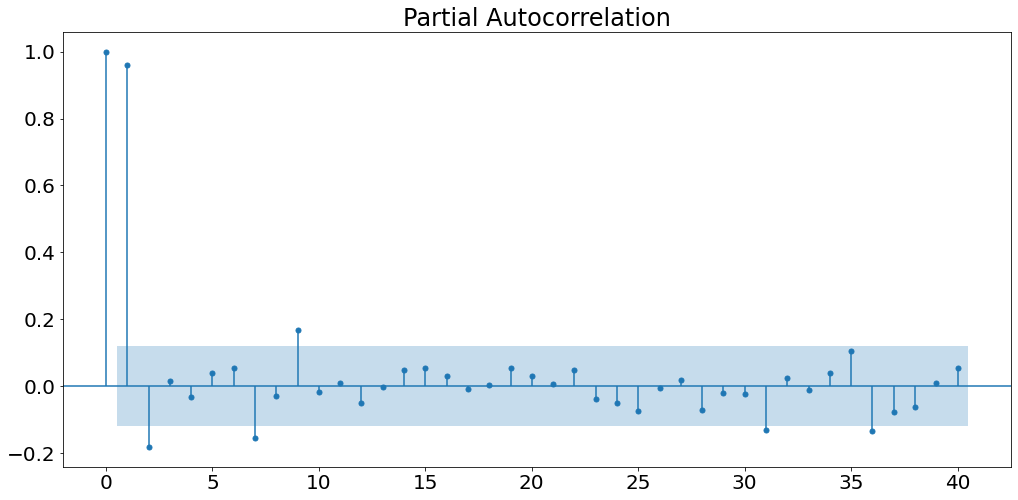

In [29]:
rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20
plot_pacf(x, lags = 40);

# Final version of the dataset
<hr style = "border:2px solid black" ></hr>

In [30]:
clean_df

,DATE,COE$,COE$_1,#Bids,Quota,Open?
0,1990-08-01 00:00:00,7400.0,7750.0,656,472,0
1,1990-09-01 00:00:00,11100.0,7400.0,1462,468,0
2,1990-10-01 00:00:00,5002.0,11100.0,633,472,0
3,1990-11-01 00:00:00,3170.0,5002.0,952,511,0
4,1990-12-01 00:00:00,3410.0,3170.0,919,471,0
...,...,...,...,...,...,...
260,2006-11-15 00:00:00,14156.0,12605.0,2122,1360,1
261,2006-12-01 00:00:00,14501.0,14156.0,1981,1287,1
262,2006-12-15 00:00:00,14669.0,14501.0,1991,1283,1
263,2007-01-01 00:00:00,13499.0,14669.0,1708,1290,1


In [31]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    265 non-null    object 
 1   COE$    265 non-null    float64
 2   COE$_1  265 non-null    float64
 3   #Bids   265 non-null    int64  
 4   Quota   265 non-null    int64  
 5   Open?   265 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 12.5+ KB


In [32]:
y = clean_df[ "COE$" ]

<div class="alert alert-block alert-info">
<font color=black><br>

- The reason why we have removed the log transform is that some of the value were infinitive.  

<br></font>
</div>

In [33]:
x = clean_df.drop(clean_df.columns[[0 ,4]] , axis = 1) 
#x = x.apply (np.log) 
#x = pd.concat([x, clean_df["Open?"]], axis = 1)

In [34]:
colu = x.columns
x

,COE$,COE$_1,#Bids,Open?
0,7400.0,7750.0,656,0
1,11100.0,7400.0,1462,0
2,5002.0,11100.0,633,0
3,3170.0,5002.0,952,0
4,3410.0,3170.0,919,0
...,...,...,...,...
260,14156.0,12605.0,2122,1
261,14501.0,14156.0,1981,1
262,14669.0,14501.0,1991,1
263,13499.0,14669.0,1708,1


In [35]:
scaler_x = preprocessing .MinMaxScaler(feature_range=(0, 1))

In [36]:
x = np.array(x).reshape((len(x), 4)) 
x = scaler_x.fit_transform (x)

In [37]:
scaler_y = preprocessing .MinMaxScaler( feature_range=(0, 1))
y = np.array(y).reshape((len(y), 1)) 
#y = np.log(y)
y = scaler_y.fit_transform (y)

# Train and test sets
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-info">
<font color=black><br>

- We need to provide KERAS with the right inputs.
- The shape is of the form **(number of samples, number of features, time_steps)**. 
- For example, the train set contains 250 examples on four features for each time step:

<br></font>
</div>

In [38]:
end = len(x) - 1
learn_end = int(end * 0.954)
x_train = x[ 0 : learn_end - 1 ,]
x_test = x[learn_end : end - 1 ,]
y_train = y[1 : learn_end ]
y_test = y[learn_end + 1 : end] 
x_train = x_train.reshape(x_train.shape + (1,)) 
x_test = x_test.reshape(x_test.shape + (1,))

In [39]:
x_train.shape

(250, 4, 1)

In [40]:
x_test.shape

(12, 4, 1)

# RNNs
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-info">
<font color=black><br>

- Unlike the deep neural network, RNNs contain hidden states which are distributed across time. 
- This allows them to efficiently store a lot of information about the past.
- As with a regular deep neural network, the non-linear dynamics allows them to update their hidden state in complicated ways. 
- **What exactly does a RNN do?** The delay unit enables the network to have short-term memory by **storing** the hidden layer activation values (or output) of the previous time step. It releases these values back into the network at the subsequent time step.

<br></font>
</div>

<div class="alert alert-block alert-info">
<font color=black><br>

- The model is stored in fit1. Each layer is added via the add function. 
- It consists of a RNN with 8 delay nodes with tanh activation functions.
- The input_shape argument takes the number of features (in this case 4) and the number of time steps (in this case 1).
- The output layer is a fully connected layer with 1 output (our COE forecast) via a linear activation function. 

<br></font>
</div>

In [41]:
seed = 2016
np.random.seed(seed)
fit1 = Sequential() 
RNN_layer = SimpleRNN(units = 8, activation = "tanh", input_shape=(4, 1))
fit1.add(RNN_layer) 
fit1.add(Dense(units = 1, activation = "linear"))

<div class="alert alert-block alert-info">
<font color=black><br>

- **How do you set the optimum value of momentum?** Reduce the learning rate when using a lot of momentum.
- **Nesterov**’s accelerated gradient descent is a first-order optimization method designed to improve stability and speed up convergence of gradient descent by a adding momentum term to the gradient.

<br></font>
</div>

In [42]:
sgd = SGD(learning_rate = 0.0001, momentum = 0.95, nesterov = True)
fit1.compile(loss = "mean_squared_error", optimizer = sgd)

<div class="alert alert-block alert-info">
<font color=black><br>

- Mini batching is one common approach to speeding up neu- ral network computation.
- It involves computing the gradient on several training examples (batches) together, rather than for each individual example as happens in the original stochastic gradient descent algorithm.
 
<br></font>
</div>

In [43]:
fit1.fit(x_train, y_train, batch_size = 10, epochs = 700)

Epoch 1/700
25/25 [==============================] - 16s 2ms/step - loss: 0.5352
Epoch 2/700
25/25 [==============================] - 0s 2ms/step - loss: 0.2680
Epoch 3/700
25/25 [==============================] - 0s 2ms/step - loss: 0.1312
Epoch 4/700
25/25 [==============================] - 0s 2ms/step - loss: 0.1025
Epoch 5/700
25/25 [==============================] - 0s 2ms/step - loss: 0.1080
Epoch 6/700
25/25 [==============================] - 0s 2ms/step - loss: 0.0962
Epoch 7/700
25/25 [==============================] - 0s 2ms/step - loss: 0.0804
Epoch 8/700
25/25 [==============================] - 0s 2ms/step - loss: 0.0692
Epoch 9/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0671
Epoch 10/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0720
Epoch 11/700
25/25 [==============================] - 0s 2ms/step - loss: 0.0592
Epoch 12/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0609
Epoch 13/700
25/25 [================

25/25 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 203/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 204/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 205/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 206/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 207/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 208/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 209/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 210/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 211/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 212/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 213/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 214/700
25/25 [=========

25/25 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 303/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 304/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 305/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 306/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 307/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 308/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 309/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 310/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 311/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 312/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 313/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 314/700
25/25 [=========

25/25 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 403/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 404/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 405/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 406/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 407/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 408/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 409/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 410/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 411/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 412/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 413/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 414/700
25/25 [=========

25/25 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 503/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 504/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 505/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 506/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 507/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 508/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 509/700
25/25 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 510/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 511/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 512/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 513/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 514/700
25/25 [=========

25/25 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 603/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 604/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 605/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 606/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 607/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 608/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 609/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 610/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 611/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 612/700
25/25 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 613/700
25/25 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 614/700
25/25 [=========

In [44]:
score_train = fit1.evaluate(x_train , y_train, batch_size = 10)

25/25 [==============================] - 1s 1ms/step - loss: 0.0026


In [45]:
score_test = fit1.evaluate(x_test , y_test,batch_size = 10)

2/2 [==============================] - 0s 2ms/step - loss: 1.1942e-04


In [46]:
# Overfitting? test set score better than train score?
print(score_train)
print(score_test)

0.0025742463767528534
0.00011941606499021873


In [48]:
# convert the predictions back to their original scale
pred1 = fit1.predict(x_test)
pred1 = scaler_y.inverse_transform(np.array(pred1).reshape((len(pred1), 1)))

In [49]:
pred1 #= np.exp(pred1)
# Use this is you are using log scale
#pred1 = np.exp(pred1)

array([[11497.224],
       [11113.567],
       [11341.033],
       [12604.598],
       [13782.927],
       [15206.433],
       [15261.301],
       [13847.233],
       [13125.868],
       [14312.64 ],
       [14812.785],
       [15014.554]], dtype=float32)

In [50]:
print(colu)
print(x_test[0])

Index(['COE$', 'COE$_1', '#Bids', 'Open?'], dtype='object')
[[0.09619046]
 [0.10578643]
 [0.30913216]
 [1.        ]]


In [53]:
print(len(x_test))
print(len(pred1))

12
12


# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-warning">
<font color=black>

- Lewis, N. D. "Deep Time Series Forecasting with Python." Create Space Independent Publishing Platform (2016).
- [Link to the xls dataset download](https://goo.gl/WymYzd)
- [How to change dataframe value entries](https://flutterq.com/attributeerror-dataframe-object-has-no-attribute-set_value/)
- [Deep learning: the final frontier for signal processing and time series analysis?](https://alexrachnog.medium.com/deep-learning-the-final-frontier-for-signal-processing-and-time-series-analysis-734307167ad6)

</font>
</div>